In [2]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import scipy.stats as st
#import functions as fun

In [3]:
#mods = fun.models()
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [13]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .05
mpl.rcParams['figure.subplot.top']    = .99
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .99
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,4


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [5]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('../rawdata/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('../rawdata/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'../rawdata/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [6]:
def get_vars(scen):
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))
    
    for m,model in enumerate(mods):

        #Get zos
        file = f'../rawdata/zos/CorrectedZOS_EXP{scen}_{model}.nc'
        with xr.open_dataset(file) as ds:
            stdn[m,:,:] = np.nanmean(ds['CorrectedZOS_reg'][-20:,:,:].values,axis=0)

        #Add steric expansion    
        with xr.open_dataset(f'../data/steric/{model}_{scen}.nc') as ds:
            stdn[m,:,:] += np.nanmean(ds['SLR'][-20:].values)
            
        #Add Antarctic dyn
        with xr.open_dataset(f'../data/Adyn/{model}_{scen}.nc') as ds:
            adyn[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a

        #Add Antarctic smb
        with xr.open_dataset(f'../data/Asmb/{model}_{scen}.nc') as ds:
            asmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a     

        #Add Greenland smb
        with xr.open_dataset(f'../data/Gsmb/{model}_{scen}.nc') as ds:  
            gsmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_gr

        #Add glaciers
        for r in range(1,20):
            with xr.open_dataset(f'../data/glacier/{model}_{scen}_{r}.nc') as ds:
                glac[m,:,:] += np.nanmean(ds['SLR'][-20:].values)*fp_gl[r-1,:,:]
                
    return stdn,adyn,asmb,gsmb,glac

In [7]:
cmap = plt.get_cmap('cmo.diff',16)

In [8]:
def plot_cov(n,var1,var2,scov,ylab='',xlab=''):
    cov = np.zeros((len(lat),len(lon)))
    
    for j in range(len(lat)):
        for i in range(len(lon)):
            cov[j,i] = st.spearmanr(var1[:,j,i],var2[:,j,i])[0]
        
    ax = fig.add_subplot(4,4,n,projection=ccrs.Robinson(central_longitude=200))
    
    cov[np.isnan(slr_md)] = np.nan
    im = ax.pcolormesh(lon,lat,cov,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap=cmap)
    
    ax.text(-.01,.5,ylab,transform=ax.transAxes,rotation='vertical',va='bottom',ha='center',rotation_mode='anchor')
    ax.text(.5,-.01,xlab,transform=ax.transAxes,va='top',ha='center')
#    ax.text(.2,.7,scov,size=12,weight='bold',ha='center',transform=ax.transAxes,color='tab:orange')
    
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)
    print(ylab,xlab)
    return im

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


glaciers 
Ant. SMB 
Ant. dyn. 
sterodynamic Greenland SMB
 
 
 glaciers
 
 Antarctic SMB
 Antarctic dyn.


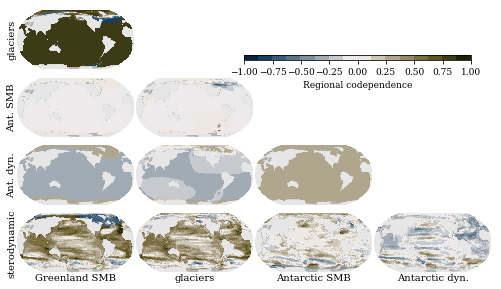

In [14]:
for scen in ['rcp45']:
    stdn,adyn,asmb,gsmb,glac = get_vars(scen)

    fig = plt.figure()

    im = plot_cov(1,glac,gsmb,0,ylab='glaciers')
    im = plot_cov(5,asmb,gsmb,1,ylab='Ant. SMB')
    im = plot_cov(9,adyn,gsmb,0,ylab='Ant. dyn.')
    im = plot_cov(13,stdn,gsmb,1,ylab='sterodynamic',xlab='Greenland SMB')
    im = plot_cov(6,asmb,glac,0)
    im = plot_cov(10,adyn,glac,0)
    im = plot_cov(14,stdn,glac,0,xlab='glaciers')
    im = plot_cov(11,adyn,asmb,0)
    im = plot_cov(15,stdn,asmb,1,xlab='Antarctic SMB')
    im = plot_cov(16,stdn,adyn,0,xlab='Antarctic dyn.')


    cax = fig.add_axes([.5,.8,.45,.02])
    cb = plt.colorbar(im,cax=cax,orientation='horizontal')
    cb.set_label('Regional codependence')

    figname = f'posterplot_regcov_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=600)
    plt.show()
    plt.close()